In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
#import strax
import straxbra
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd
import patrick_stylez as ps
from scipy.stats import chi2 

Using TensorFlow backend.


In [2]:
# ctx = straxbra.XebraContext()
# run = '00158'
# peaks_data = ctx.get_array(run, 'peaks')
# waveform = peaks_data['data']
# integral = peaks_data['area']
# width = peaks_data['width'][:,5]
# timestamp = peaks_data['time']
# area_per_channel = peaks_data['area_per_channel']

# extract the s2 and the drifttime

In [4]:
electron_lifetime_list = []
electron_lifetime_error_list = []
s1_all_runs = {}
s2_all_runs = {}
drifttime_all_runs = {}
# run_list = ['00218','00219','00220','00221','00222','00223','00224','00225','00226','00227','00228','00229','00230',
#            '00231','00232','00233','00234','00235','00236','00237','00238','00239','00240','00241','00242','00243',
#             '00244','00245','00246','00247','00248','00249','00250']
run_list = ['00201']
left_edge  = [0, 0]
right_edge = [40500.0, -71.5]
a = ((right_edge[1])-(left_edge[1])) / ((right_edge[0])-(left_edge[0]))
b = (right_edge[1]) - a * (right_edge[0])
fiducial_r = 21

def poisson_interval(k, alpha=0.318):
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0:
        low = 0.0
    low_interval = k - low
    high_interval = high - k
    return low_interval, high_interval



    
def log_gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
    return gaus


def log_fit( x, a, mu, sigma ):
    return a / x * 1. / (sigma * np.sqrt( 2. * np.pi ) ) * np.exp( -( np.log( x ) - mu )**2 / ( 2. * sigma**2 ) )

def expo(x, a, b):
    return a*np.exp(-b*x)

def compute_lifetime(s2,drifttime):


    bins_x = np.linspace(0,50,40)
    bins_y = np.logspace(2,5,40) 
    drifttime = np.array(drifttime)
    counts, xedges, yedges = np.histogram2d(drifttime/1e3, s2, bins=(bins_x, bins_y))
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    poisson_list = []
    for i in counts:
        error_per_slice = []
        for j in i:
            u =poisson_interval(j)[1]
            error_per_slice.append(u)
        poisson_list.append(error_per_slice)

    fit_range= np.linspace(10,30000,1000)



    p0 = [50,8,2]

    expectation_list = []
    error_list = []
    for i in range(5,30):   
        popt, pcov = curve_fit(log_fit, ycenter, counts[i], p0= p0, sigma = poisson_list[i], absolute_sigma = True, maxfev = 10000)
        perr = np.sqrt(np.diag(pcov))

        expectation = np.exp(popt[1]+((popt[2]**2)/2))
        expectation_list.append(expectation)


        diff_mu = expectation
        diff_sigma = expectation*popt[2]
        error_mu = perr[1]
        error_sigma = perr[2]

        error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
        error_list.append(error)


    p1=  [10000,0.1]
    x = np.linspace(5,30,25)
    popt, pcov = curve_fit(expo, x, expectation_list, sigma=error_list, p0=p1, absolute_sigma=True, maxfev= 10000)
    perr = np.sqrt(np.diag(pcov))
    lifetime =(1/popt[1])
    lifetime_error =(1/(popt[1]**2))*perr[1]
#    print('electron lifetime: ', lifetime, '+/-', lifetime_error)

    return (lifetime, lifetime_error)



def drifttime_to_z(t):
    return a * t + b


#     def CutCondition(waveform):  
#         FirstPeak_area = sum(waveform[:15])
#         SecondPeak_area = sum(waveform[15:])    
#         if  FirstPeak_area > 100 and FirstPeak_area < 500 and SecondPeak_area > 40 and SecondPeak_area  < 200: 
#             return(True)
#         else:
#             return(False)



#     def CutCondition(waveform):  
#         FirstPeak_area = sum(waveform[:15])
#         SecondPeak_area = sum(waveform[15:])
#         FirstPeak_maximum = max(waveform[:15])
#         SecondPeak_maximum = max(waveform[15:])
#         SecondPeak_index = np.where(waveform == SecondPeak_maximum)
#         SecondPeak_index_left = SecondPeak_index[0][0] -1
#         SecondPeak_index_right = SecondPeak_index[0][0] +1
#         SecondPeak_maximum_left = waveform[SecondPeak_index_left]
#         SecondPeak_maximum_right = waveform[SecondPeak_index_right]




#         if  FirstPeak_area > 100 and FirstPeak_area < 500 and SecondPeak_area > 40 and SecondPeak_area  < 200 \
#         and SecondPeak_maximum < 0.5 * FirstPeak_maximum \
#         and SecondPeak_maximum > 0.25 * FirstPeak_maximum \
#         and SecondPeak_maximum > waveform[SecondPeak_index_left] \
#         and SecondPeak_maximum > waveform[SecondPeak_index_right] \
#         : 
#             return(True)
#         else:
#             return(False)        

def CutCondition(waveform):  
    FirstPeak_area = sum(waveform[:15])
    SecondPeak_area = sum(waveform[15:])    
    if  FirstPeak_area > 80 and FirstPeak_area < 500 and SecondPeak_area > 30 and SecondPeak_area  < 200:
#         print(FirstPeak_area)
#         print(SecondPeak_area)
        return(True)
    else:
        return(False)



def S2_found(integral, width):
    if integral > 500 and width >200 and width < 2000:
        return True
    else:
        return False

def Process(waveform, i): 
    SelectionCutFlag = CutCondition(waveform[i])
    if SelectionCutFlag == True:
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if S2_found(integral = integral[i+j], width = width[i+j]):

                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:
                    if threshold_timestamp <= s2_counter_timestamp:

                        time       = timestamp[i+j] - timestamp[i]
                        drifttime.append(time)
                        s1.append(integral[i])
                        s2.append(integral[i+j])
                        z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
#                             r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)

#                             if area_per_channel[i+j][1] > 0 and area_per_channel[i+j][2] > 0 \
#                                 and area_per_channel[i+j][3] > 0 and area_per_channel[i+j][4] > 0 \
#                                 and area_per_channel[i+j][5] > 0 and area_per_channel[i+j][6] > 0 \
#                                 and area_per_channel[i+j][7] > 0 \
#                                 :

#                                 time       = timestamp[i+j] - timestamp[i]
#                                 drifttime.append(time)
#                                 s1.append(integral[i])
#                                 s2.append(integral[i+j])
#                                 z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
#                                 r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
#                                 if r_position <= fiducial_r and z_position >= -75:
#                                     time       = timestamp[i+j] - timestamp[i]
#                                     drifttime.append(time)
#                                     s1.append(integral[i])
#                                     s2.append(integral[i+j])

for run in run_list:

                            
    ctx = straxbra.XebraContext()

    peaks_data = ctx.get_array(run, 'peaks')
    position_data = ctx.get_array(run, 'peak_positions')
    waveform = peaks_data['data']
    integral = peaks_data['area']
    width = peaks_data['width'][:,5]
    timestamp = peaks_data['time']
    area_per_channel = peaks_data['area_per_channel']


    s1 = []
    s2 = []
    drifttime = []
    num = len(waveform)
    print_counter = 0.0
    for i in range(0,num-10):    
        Process(waveform,i)
        if i/num >= print_counter:
            print(round(print_counter,2), end = ' ')
            print_counter += 0.1
    print(1.0, '        Run ',run, 'done!')
    
    electron_lifetime, lifetime_error = compute_lifetime(s2,drifttime) 
    electron_lifetime_list.append(electron_lifetime)
    electron_lifetime_error_list.append(lifetime_error)
    s1_all_runs.update({run:s1})
    s2_all_runs.update({run:s2})
    drifttime_all_runs.update({run:drifttime})


0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00218 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00219 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00220 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00221 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00222 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00223 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00224 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00225 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00226 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00227 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00228 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00229 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00230 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00231 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.

In [5]:
print(electron_lifetime_list)

[120.66091750439801, 69.64395640869373, 35.20853486898245, 23.293988598965413, 16.494935741475857, 12.797652581240506, 10.071426356062993, 8.78685579497839, 8.132632479873841, 7.809322105224535, 7.906030360717378, 8.80680363886866, 9.783511764945155, 10.996475532941835, 12.782275941760266, 15.205801734178978, 17.529797052556926, 20.21922608165961, 23.2260042283411, 27.04843919860713, 29.61376194567934, 33.57034190256521, 36.868814461018665, 39.06067267115656, 43.58326787809487, 45.29538445502715, 48.92246411649175, 51.21034664641598, 53.2914576254904, 57.24538276967909, 58.873684016796574, 60.1402250802924, 61.69463097671037]


In [ ]:
#print(len(s1_all_runs['00191']))

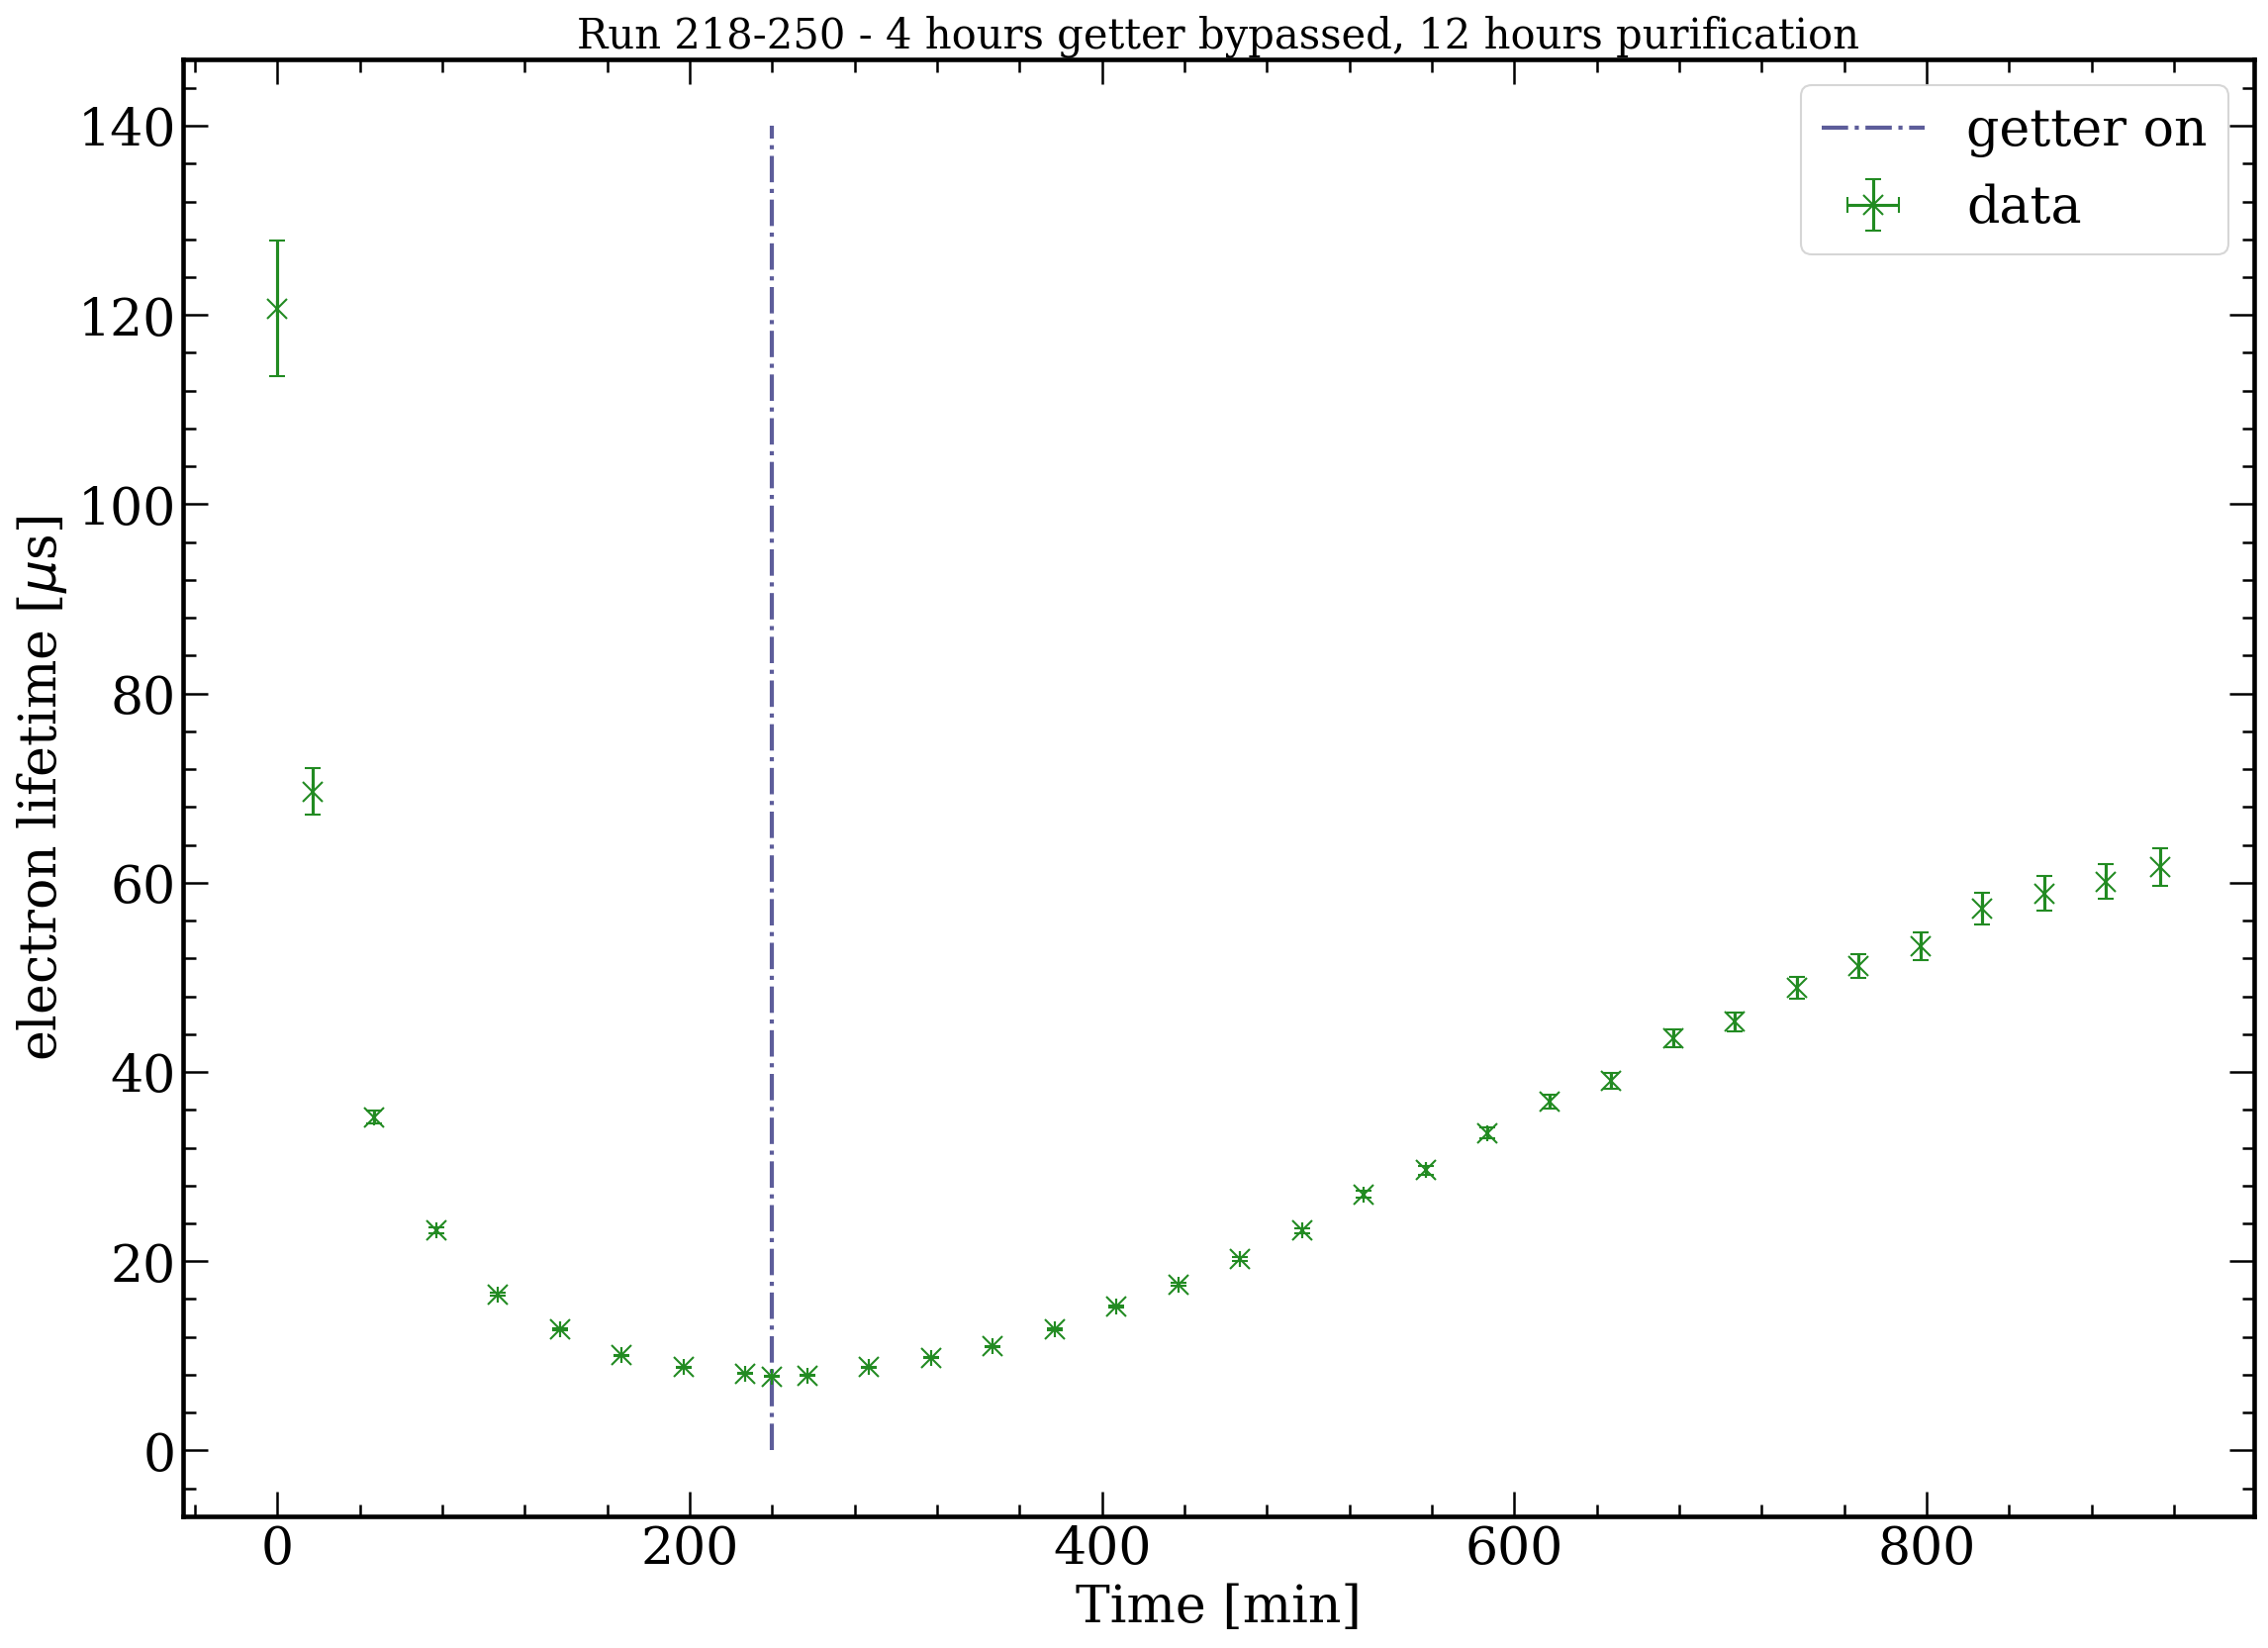

In [18]:
fig, axes = ps.styles()

Time = [0,17,47,77,107,137,167,197,227, 240, 257,287, 317,347,377,407,437,467,497,527,557,587,617,647,677,707,737,767,797,827, 857,887,913]
#positions = (1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,9,30,31,32)
# positions_electron_lifetime = positions[15:]

#labels =('218',,'219','220','221','222','223','224','225','226','227','228','229','230','231','232','233','234','235',
         #'236','237','238','239','240','241','242','243','244','245','246','247','248','249','250')
# labels_electron_lifetime = labels[15:]
# values_electron_lifetime_list = electron_lifetime_list[15:]
# error_electron_lifetime_error_list = electron_lifetime_error_list[15:]

# plt.xticks(positions, labels)



axes.errorbar(Time,electron_lifetime_list ,xerr = 0, yerr=electron_lifetime_error_list, marker = 'x', fmt='.',c = 'forestgreen',markersize='10', ecolor='forestgreen',capsize=4, label = 'data')



#axes.tick_params(axis='y', labelcolor='tab:red')
axes.vlines(x = Time[9], ymin = 0, ymax =140, linestyle = '-.', linewidth = 2, alpha = 0.7, color = 'midnightblue', label ='getter on') 

axes.set_title('Run 218-250 - 4 hours getter bypassed, 12 hours purification', fontsize = 20)
axes.set_xlabel('Time [min]')
axes.set_ylabel('electron lifetime [$\mu$s]' )

handles,labels = axes.get_legend_handles_labels()
handles = [handles[0],handles[1]]
labels = [labels[0],labels[1]]
axes.legend(handles,labels, loc = 1,prop={'size': 25})
plt.show()

In [7]:
print(len(Time))
print(len(electron_lifetime_list))

32
33


# plot the average s2 size as a function of the drifttime

In [ ]:
# fig, axes = ps.styles()




# def poisson_interval(k, alpha=0.318):
#     a = alpha
#     low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
#     if k == 0:
#         low = 0.0
#     low_interval = k - low
#     high_interval = high - k
#     return low_interval, high_interval

# s1 = np.array(s1_all_runs[run_list[0]])
# s2 = np.array(s2_all_runs[run_list[0]])
# drifttime = np.array(drifttime_all_runs[run_list[0]])
# s2_cut = []
# drifttime_cut = []

# # for i in range(len(s2_all_runs[run_list[1]])):
# #     if s2_all_runs[run_list[1]][i] < 12000:
# #         s2_cut.append(s2_all_runs[run_list[1]][i])
# #         drifttime_cut.append(drifttime_all_runs[run_list[1]][i])
        
# s2_cut        = np.array(s2_cut)
# drifttime_cut = np.array(drifttime_cut)

# bins_x = np.linspace(0,50,40)
# bins_y = np.logspace(2,5,40)
# counts, xedges, yedges = np.histogram2d(drifttime/1e3, s2, bins=(bins_x, bins_y))
# xcenter = ((xedges[:-1]+xedges[1:])/2)
# ycenter = ((yedges[:-1]+yedges[1:])/2)

# poisson_list = []

# for i in counts:
#     error_per_slice = []
#     for j in i:
#         a =poisson_interval(j)[1]
#         error_per_slice.append(a)
#     poisson_list.append(error_per_slice)
    

    
# im = axes.pcolormesh(bins_x, bins_y, counts.T, cmap='viridis', norm=mcolors.LogNorm())
# axes.set_yscale('log')
# axes.set_xlabel('Drift time [us]')
# axes.set_ylabel('S2')
# cbar = plt.colorbar(im, ax=axes)
# cbar.set_label('Counts',size=20)
# cbar.ax.tick_params(labelsize=20) 
# plt.show()


# project on the s2 axis

In [ ]:
# fig, axes = ps.styles()
# fit_range= np.linspace(10,30000,1000)
# #fit_range= np.logspace(1,4.5,1000)
# def log_gaus(x, h, mu, sigma):

#     gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
#     return gaus

# def gaus(x, h, mu, sigma):

#     gaus = h * np.exp(-(x-mu)**2         /(2*sigma**2))
#     return gaus

# p0_log_gaus = [50,8,2]
# p0_gaus = [200,10000,5000]
# expectation_list = []
# error_list = []
# #bound = 0.9*max(counts[15])

# # bounds = ((bound,-np.inf,-np.inf),(np.inf,np.inf, np.inf))


# # popt, pcov = curve_fit(log_gaus, ycenter, counts[15], p0_log_gaus, sigma = poisson_list[15], absolute_sigma = True, maxfev = 10000)
# # perr = np.sqrt(np.diag(pcov))

    
    
# # expectation = np.exp(popt[1]+((popt[2]**2)/2))    
# # diff_mu = expectation
# # diff_sigma = expectation*popt[2]
# # error_mu = perr[1]
# # error_sigma = perr[2]   
# # error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)



# # plt.scatter(ycenter, counts[15], c = 'r', marker = 'x')
# # plt.plot(fit_range, log_gaus(fit_range, *popt))


# # axes.set_xscale('log')
# # axes.set_title('Fit for each drift time slice - log(gaus) fit', fontsize = 20)
# # axes.set_xlabel('S2 area [PE]', fontsize = 20)
# # axes.set_ylabel('counts[#]', fontsize = 20)
# # perr = np.sqrt(np.diag(pcov))


# # for i in range(5,35):   
# #     popt, pcov = curve_fit(gaus, ycenter, counts[i], p0_gaus, sigma = poisson_list[i], absolute_sigma = True, maxfev=10000)
# #     axes.plot(fit_range, gaus(fit_range, *popt))
# #     perr = np.sqrt(np.diag(pcov))

    
    
# #     expectation = popt[1]
# #     expectation_list.append(expectation)
# #     error = perr[1]
# #     error_list.append(error)
    





# for i in range(5,30):   
#     popt, pcov = curve_fit(log_gaus, ycenter, counts[i], p0_log_gaus, sigma = poisson_list[i], absolute_sigma = True, maxfev=10000)
#     axes.plot(fit_range, log_gaus(fit_range, *popt))
#     perr = np.sqrt(np.diag(pcov))

    
    
#     expectation = np.exp(popt[1]+((popt[2]**2)/2))
#     expectation_list.append(expectation)

    
#     diff_mu = expectation
#     diff_sigma = expectation*popt[2]
#     error_mu = perr[1]
#     error_sigma = perr[2]
    
#     error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
#     error_list.append(error)

    


# plt.show()
# #print(expectation_list[11])
# # print('expectation +/- error: ', expectation, '+/-', error)
# # print('expectation +/- error: ', expectation_list[15], '+/-', error_list[15])

In [ ]:
# fig, axes = ps.styles()

# def expo(x, a, b):
#     return a*np.exp(-b*x)

# p0=  [10000,0.1]
# x = np.linspace(5,30,25)



# popt, pcov = curve_fit(expo, x, expectation_list, sigma=error_list, p0=p0, absolute_sigma=True, maxfev= 10000)
# perr = np.sqrt(np.diag(pcov))
# #lifetime = "%.2f" % (1/popt[1])
# #lifetime_error = "%.2f" % ((1/(popt[1]**2))*perr[1])
# lifetime_error = f"{((1/(popt[1]**2))*perr[1]):.0f}"



# lifetime = f"{1/popt[1]:.0f}"
# chi_squared =  (np.sum((expectation_list - expo(x, *popt))**2 / np.array(error_list)**2))
# Reduced_chi_squared ="%.2f" %( chi_squared / len(x))




# axes.errorbar(x, expectation_list, yerr=error_list, xerr=0, fmt = 'rx', label = 'average S2 size' )
# axes.plot(x, expo(x, *popt), 'g--', label = 'electron lifetime = '+str(lifetime)+ ' +/- '+str(lifetime_error)+' us')
# axes.plot([], [], ' ', label="reduced chi squared: "+Reduced_chi_squared)


# # axes.set_xlim([0,40])
# # axes.set_ylim([8000,11000])
# axes.set_title('electron lifetime fit - Run '+run[2:]+' - Getter on')

# axes.set_xlabel('Drift time [us]')
# axes.set_ylabel('S2 area [PE]')
# axes.legend(prop={'size': 20})
# plt.show()

# print('this is lamba: ', popt[1])
# print('this is 1/lamba: ', 1/popt[1] )
# print('electron lifetime: ', lifetime, '+/-', lifetime_error)